In [17]:
%pip install langchain
%pip install langchain-community
%pip install langchain-core
%pip install langchain-openai
%pip install -U matplotlib
%pip install tiktoken
!python -m spacy download en_core_web_lg

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [1]:
original_document = ''
# open file A Survey on In-context Learning.txt

with open('A Survey on In-context Learning.txt', 'r') as file:
  original_document = file.read()

In [11]:
import re
from langchain_openai import OpenAIEmbeddings
from sklearn.metrics.pairwise import cosine_similarity
import unicodedata
import matplotlib.pyplot as plt
import tiktoken
import spacy

enc = tiktoken.get_encoding("cl100k_base")
nlp = spacy.load("en_core_web_lg")

# OpenAI APIKEY
openai_api_key = ""

def merge_short_sentences(sentences, min_length=100):
    merged_sentences = []
    current_sentence = ""

    while sentences:
        sentence = sentences.pop(0)
        if len(sentence) < min_length:
            current_sentence += sentence
            if len(current_sentence) >= min_length:
                merged_sentences.append(current_sentence)
                current_sentence = ""
        else:
            if current_sentence:
                merged_sentences.append(current_sentence)
                current_sentence = ""
            merged_sentences.append(sentence)

    if current_sentence:
        # Append any remaining sentence that is not empty
        merged_sentences.append(current_sentence)

    # Check if there are still short sentences left and merge them if necessary
    i = 0
    while i < len(merged_sentences) - 1:
        if len(merged_sentences[i]) < min_length:
            merged_sentences[i] += merged_sentences.pop(i + 1)
        else:
            i += 1

    return merged_sentences

def split_text_into_sentences(text):
    # Use the loaded model to process the text
    doc = nlp(text)
    # Extract sentences from the processed text
    sentences = [sent.text.strip() for sent in doc.sents]
    print(f"{len(sentences)} sentences.")
    # Merge short sentences
    merged_sentences = merge_short_sentences(sentences)
    print(f"{len(merged_sentences)} merged_sentences.")
    return merged_sentences


sentences = split_text_into_sentences(original_document)

def normalize_text(text):
    text = re.sub(' +', ' ', text)   # remove extra spaces
    text = text.replace('\n', ' ')   # remove newlines
    text = unicodedata.normalize('NFD', text).encode('ascii', 'ignore')   # remove spanish accents
    text = text.decode("utf-8")
    return text.strip()   # remove whitespaces at the beginning and end of the string

sentences = [{'sentence': x, 'index' : i} for i, x in enumerate(sentences)]

def combine_sentences(sentences, buffer_size=1):
    # Go through each sentence dict
    for i in range(len(sentences)):

        # Create a string that will hold the sentences which are joined
        combined_sentence = ''

        # Add sentences before the current one, based on the buffer size.
        for j in range(i - buffer_size, i):
            # Check if the index j is not negative (to avoid index out of range like on the first one)
            if j >= 0:
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += sentences[j]['sentence'] + ' '

        # Add the current sentence
        combined_sentence += sentences[i]['sentence']

        # Add sentences after the current one, based on the buffer size
        for j in range(i + 1, i + 1 + buffer_size):
            # Check if the index j is within the range of the sentences list
            if j < len(sentences):
                # Add the sentence at index j to the combined_sentence string
                combined_sentence += ' ' + sentences[j]['sentence']

        # Then add the whole thing to your dict
        # Store the combined sentence in the current sentence dict
        sentences[i]['combined_sentence'] = combined_sentence

    return sentences

sentences = combine_sentences(sentences)

# model="text-embedding-3-large"
oaiembeds = OpenAIEmbeddings(
    openai_api_key=openai_api_key
    # model ada2 for default
)

embeddings_store = []

if embeddings_store == []:
    print("Calculating embeddings")
    embeddings = oaiembeds.embed_documents([x['combined_sentence'] for x in sentences])
    embeddings_store = embeddings
else:
    print("Using stored embeddings")
    embeddings = embeddings_store

for i, sentence in enumerate(sentences):
    sentence['combined_sentence_embedding'] = embeddings[i]

def calculate_cosine_distances(sentences):
    distances = []
    for i in range(len(sentences) - 1):
        embedding_current = sentences[i]['combined_sentence_embedding']
        embedding_next = sentences[i + 1]['combined_sentence_embedding']

        # Calculate cosine similarity
        similarity = cosine_similarity([embedding_current], [embedding_next])[0][0]

        # Convert to cosine distance
        distance = 1 - similarity

        # Append cosine distance to the list
        distances.append(distance)

        # Store distance in the dictionary
        sentences[i]['distance_to_next'] = distance

    # Optionally handle the last sentence
    sentences[-1]['distance_to_next'] = None  # or a default value

    return distances, sentences

distances, sentences = calculate_cosine_distances(sentences)

plt.plot(distances)

884 sentences.
477 merged_sentences.


ValidationError: 1 validation error for OpenAIEmbeddings
__root__
  Did not find openai_api_key, please add an environment variable `OPENAI_API_KEY` which contains it, or pass `openai_api_key` as a named parameter. (type=value_error)

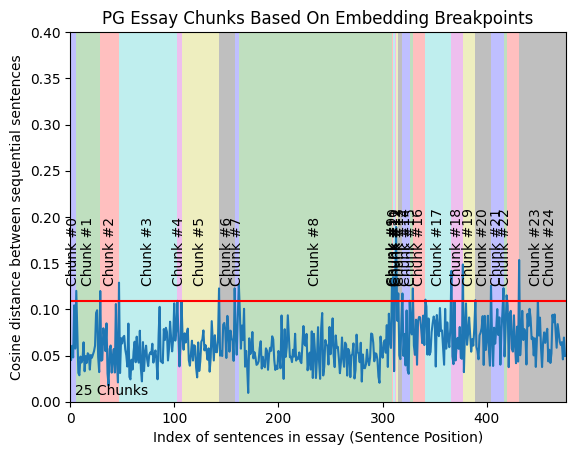

In [9]:
import numpy as np

plt.plot(distances)

# For ada2 .2;
# For text3 .4

y_upper_bound = .2
plt.ylim(0, y_upper_bound)
plt.xlim(0, len(distances))

# We need to get the distance threshold that we'll consider an outlier
# We'll use numpy .percentile() for this -> if ada2 95; if text3 96

breakpoint_percentile_threshold = 95

breakpoint_distance_threshold = np.percentile(distances, breakpoint_percentile_threshold) # If you want more chunks, lower the percentile cutoff
plt.axhline(y=breakpoint_distance_threshold, color='r', linestyle='-')

# Then we'll see how many distances are actually above this one
num_distances_above_theshold = len([x for x in distances if x > breakpoint_distance_threshold]) # The amount of distances above your threshold
plt.text(x=(len(distances)*.01), y=y_upper_bound/50, s=f"{num_distances_above_theshold + 1} Chunks")

# Then we'll get the index of the distances that are above the threshold. This will tell us where we should split our text
indices_above_thresh = [i for i, x in enumerate(distances) if x > breakpoint_distance_threshold] # The indices of those breakpoints on your list

# Start of the shading and text
colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k']
for i, breakpoint_index in enumerate(indices_above_thresh):
    start_index = 0 if i == 0 else indices_above_thresh[i - 1]
    end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)

    plt.axvspan(start_index, end_index, facecolor=colors[i % len(colors)], alpha=0.25)
    plt.text(x=np.average([start_index, end_index]),
        y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
        s=f"Chunk #{i}", horizontalalignment='center',
        rotation='vertical')

# # Additional step to shade from the last breakpoint to the end of the dataset
if indices_above_thresh:
    last_breakpoint = indices_above_thresh[-1]
    if last_breakpoint < len(distances):
        plt.axvspan(last_breakpoint, len(distances), facecolor=colors[len(indices_above_thresh) % len(colors)], alpha=0.25)
        plt.text(x=np.average([last_breakpoint, len(distances)]),
                y=breakpoint_distance_threshold + (y_upper_bound)/ 20,
                s=f"Chunk #{i+1}",
                rotation='vertical')

plt.title("PG Essay Chunks Based On Embedding Breakpoints")
plt.xlabel("Index of sentences in essay (Sentence Position)")
plt.ylabel("Cosine distance between sequential sentences")
plt.show()

def export ():
    # export the chunks to pandas dataframe csv
    import pandas as pd

    chunks = []
    for i, breakpoint_index in enumerate(indices_above_thresh):
        start_index = 0 if i == 0 else indices_above_thresh[i - 1]
        end_index = breakpoint_index if i < len(indices_above_thresh) - 1 else len(distances)
        chunk = ' '.join([sentences[x]['sentence'] for x in range(start_index, end_index)])
        chunks.append(chunk)

    df = pd.DataFrame(chunks, columns=['chunk'])
    df.to_csv('chunks_v3.csv', index=False)



In [10]:
# Initialize the start index
start_index = 0

# Create a list to hold the grouped sentences
chunks = []

# Iterate through the breakpoints to slice the sentences
for index in indices_above_thresh:
    # The end index is the current breakpoint
    end_index = index

    # Slice the sentence_dicts from the current start index to the end index
    group = sentences[start_index:end_index + 1]
    combined_text = ' '.join([d['sentence'] for d in group])
    chunks.append(combined_text)
    # Update the start index for the next group
    start_index = index + 1

# The last group, if any sentences remain
if start_index < len(sentences):
    combined_text = ' '.join([d['sentence'] for d in sentences[start_index:]])
    chunks.append(combined_text)

# grouped_sentences now contains the chunked sentences

In [46]:
for i, chunk in enumerate(chunks[:2]):
    buffer = 200
    print (f"Chunk #{i}")
    print (chunk[:buffer].strip())
    print ("...")
    print (chunk[-buffer:].strip())
    print ("\n")

Chunk #0
A Survey on In-context Learning Qingxiu Dong1 , Lei Li1 , Damai Dai1 , Ce Zheng1 , Zhiyong Wu2 , Baobao Chang1 , Xu Sun1 , Jingjing Xu2 , Lei Li3 and Zhifang Sui1 1 MOE Key Lab of Computational Lingui
...
augmented with a few examples. It has been a new trend to explore ICL to evaluate and extrapolate the ability of LLMs.In this paper, we aim to survey and summarize the progress and challenges of ICL.


Chunk #1
We first present a formal definition of ICL and clarify its correlation to related studies.Then, we organize and discuss advanced techniques, including training strategies, demonstration designing str
...
Text] Sentiment:[Label] Text Label 1 0 0 … Figure 1: Illustration of in-context learning. ICL requires a piece of demonstration context containing a few examples written in natural language templates.


